# SCIL Latent Space Analysis

This notebook analyzes the learned embedding space from the SCIL model to verify that:
1. Embeddings are clustered by action labels (similar actions → similar embeddings)
2. SupCon loss is creating meaningful structure
3. The latent space has good separability for downstream tasks

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import seaborn as sns

from models import SCILEncoder
from models_pretrained import SCILEncoderPretrained
from model_efficientnet import SCILEncoderEfficientNet
from dataset import MarioSCILDataset
from torch.utils.data import DataLoader

# Set style for prettier plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Load Trained Model and Extract Embeddings

In [2]:
# Configuration
MODEL_PATH = "scil_encoder_mario_1_2_efficientnet_b1_lam2.pth"
DATA_FILES = "mario_1_2_expert.pkl" #"mario_*_expert.pkl"

NUM_SAMPLES = 2000  # Number of samples to analyze
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

# Load model (no projection_dim parameter anymore)
model = SCILEncoderEfficientNet(num_actions=7, variant='b1', freeze_backbone=False).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print(f"✓ Loaded model from {MODEL_PATH}")

# Load dataset
dataset = MarioSCILDataset(DATA_FILES, img_size=224, use_imagenet_norm=True)
loader = DataLoader(dataset, batch_size=128, shuffle=False)
print(f"✓ Loaded dataset: {len(dataset)} samples")

Using device: cuda
EfficientNet-B1 backbone unfrozen - fine-tuning all layers


/tmp/ipykernel_87332/3247286185.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


✓ Loaded model from scil_encoder_mario_1_2_efficientnet_b1_lam2.pth
Loading 1 file(s)...
  Loading mario_1_2_expert.pkl...
    Added 12467 frames
Total frames loaded: 12467
✓ Loaded dataset: 12467 samples


In [3]:
# Extract embeddings (h) from SCIL model
all_embeddings_h = []  # Backbone embeddings (used for BOTH SupCon and policy)
all_actions = []
all_logits = []

# shuffle data, optionally
shuffle=False

if shuffle:
    print("Shuffling dataset...")
    indices = torch.randperm(len(dataset))
    dataset = torch.utils.data.Subset(dataset, indices)
    loader = DataLoader(dataset, batch_size=128, shuffle=False)

print("Extracting embeddings...")
with torch.no_grad():
    for i, (obs, actions) in enumerate(loader):
        obs, actions = obs.to(DEVICE), actions.to(DEVICE)
        
        # Forward pass - model now returns only (action_logits, h)
        action_logits, h = model(obs)
        
        # Store
        all_embeddings_h.append(h.cpu())
        all_actions.append(actions.cpu())
        all_logits.append(action_logits.cpu())
        
        # Limit samples for faster analysis
        if len(all_actions) * 128 >= NUM_SAMPLES:
            break
        
        if (i+1) % 10 == 0:
            print(f"  Processed {(i+1)*128} samples...")

# Concatenate
embeddings_h = torch.cat(all_embeddings_h, dim=0).numpy()[:NUM_SAMPLES]
actions = torch.cat(all_actions, dim=0).numpy()[:NUM_SAMPLES]
logits = torch.cat(all_logits, dim=0).numpy()[:NUM_SAMPLES]

print(f"\n✓ Extracted embeddings:")
print(f"  - SCIL embeddings (h): {embeddings_h.shape}")
print(f"  - Actions: {actions.shape}")
print(f"  - Action distribution: {np.bincount(actions)}")

Extracting embeddings...
  Processed 1280 samples...

✓ Extracted embeddings:
  - SCIL embeddings (h): (2000, 1280)
  - Actions: (2000,)
  - Action distribution: [750 719 199   0   0 213 119]


## 2. Quantitative Analysis: Clustering Quality

In [4]:
def compute_clustering_metrics(embeddings, labels, name="Embeddings"):
    """Compute silhouette score and separation ratio"""
    
    # Silhouette score: measures cluster quality (-1 to 1, higher better)
    silhouette = silhouette_score(embeddings, labels)
    
    # Compute intra-class and inter-class distances
    intra_distances = []
    inter_distances = []
    
    unique_labels = np.unique(labels)
    for label in unique_labels:
        label_mask = labels == label
        if label_mask.sum() < 2:
            continue
        
        label_embeddings = embeddings[label_mask]
        other_embeddings = embeddings[~label_mask]
        
        # Intra-class distance (within same action)
        if len(label_embeddings) > 1:
            intra_dist = cdist(label_embeddings, label_embeddings).mean()
            intra_distances.append(intra_dist)
        
        # Inter-class distance (to other actions)
        if len(other_embeddings) > 0:
            inter_dist = cdist(label_embeddings, other_embeddings).mean()
            inter_distances.append(inter_dist)
    
    avg_intra = np.mean(intra_distances)
    avg_inter = np.mean(inter_distances)
    separation_ratio = avg_inter / avg_intra if avg_intra > 0 else 0
    
    return {
        'silhouette': silhouette,
        'avg_intra': avg_intra,
        'avg_inter': avg_inter,
        'separation_ratio': separation_ratio,
        'name': name
    }

# Analyze SCIL embeddings (h) - shaped by SupCon loss
print("="*60)
print("CLUSTERING QUALITY METRICS")
print("="*60)

metrics_h = compute_clustering_metrics(embeddings_h, actions, "SCIL Embeddings (h)")

print(f"\n{metrics_h['name']}:")
print(f"  Silhouette Score:       {metrics_h['silhouette']:.4f}")
print(f"  Avg Intra-class Dist:   {metrics_h['avg_intra']:.4f} (lower = tighter clusters)")
print(f"  Avg Inter-class Dist:   {metrics_h['avg_inter']:.4f} (higher = better separation)")
print(f"  Separation Ratio:       {metrics_h['separation_ratio']:.4f}")

# Interpretation
if metrics_h['silhouette'] > 0.7:
    print("  → ✅ EXCELLENT clustering!")
elif metrics_h['silhouette'] > 0.5:
    print("  → ✅ GOOD clustering")
elif metrics_h['silhouette'] > 0.3:
    print("  → ⚠️  MODERATE clustering")
else:
    print("  → ❌ POOR clustering")

if metrics_h['separation_ratio'] > 3.0:
    print("  → ✅ EXCELLENT separation between actions!")
elif metrics_h['separation_ratio'] > 2.0:
    print("  → ✅ GOOD separation between actions")
else:
    print("  → ⚠️  Weak separation between actions")

print("\n" + "="*60)
print("💡 These embeddings are shaped by BOTH L_pred AND L_SupCon!")
print("   High scores = SupCon is successfully clustering similar actions")
print("="*60)

CLUSTERING QUALITY METRICS

SCIL Embeddings (h):
  Silhouette Score:       0.5133
  Avg Intra-class Dist:   3.7727 (lower = tighter clusters)
  Avg Inter-class Dist:   10.1630 (higher = better separation)
  Separation Ratio:       2.6939
  → ✅ GOOD clustering
  → ✅ GOOD separation between actions

💡 These embeddings are shaped by BOTH L_pred AND L_SupCon!
   High scores = SupCon is successfully clustering similar actions


## 3. t-SNE Visualization (as in SCIL Paper)

In [5]:
# Compute t-SNE for SCIL embeddings
print("Computing t-SNE projection (this may take a minute)...")

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_h_tsne = tsne.fit_transform(embeddings_h)
print("  ✓ t-SNE done")

Computing t-SNE projection (this may take a minute)...


/home/antonioricciardi/projects/scil_saps/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  ✓ t-SNE done


In [6]:
# Compute ALL THREE dimensionality reductions
from umap import UMAP

print("Computing dimensionality reductions...")

# 1. PCA (fast, linear, global structure)
print("  Computing PCA...")
pca = PCA(n_components=2, random_state=42)
embeddings_h_pca = pca.fit_transform(embeddings_h)
print(f"    ✓ PCA done (explained variance: {pca.explained_variance_ratio_.sum():.2%})")

# 2. UMAP (fast, non-linear, local+global structure)
print("  Computing UMAP...")
umap_model = UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.1)
embeddings_h_umap = umap_model.fit_transform(embeddings_h)
print("    ✓ UMAP done")

# t-SNE already computed in previous cell
print("  ✓ All dimensionality reductions complete!")

/home/antonioricciardi/projects/scil_saps/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing dimensionality reductions...
  Computing PCA...
    ✓ PCA done (explained variance: 67.74%)
  Computing UMAP...


/home/antonioricciardi/projects/scil_saps/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ✓ UMAP done
  ✓ All dimensionality reductions complete!


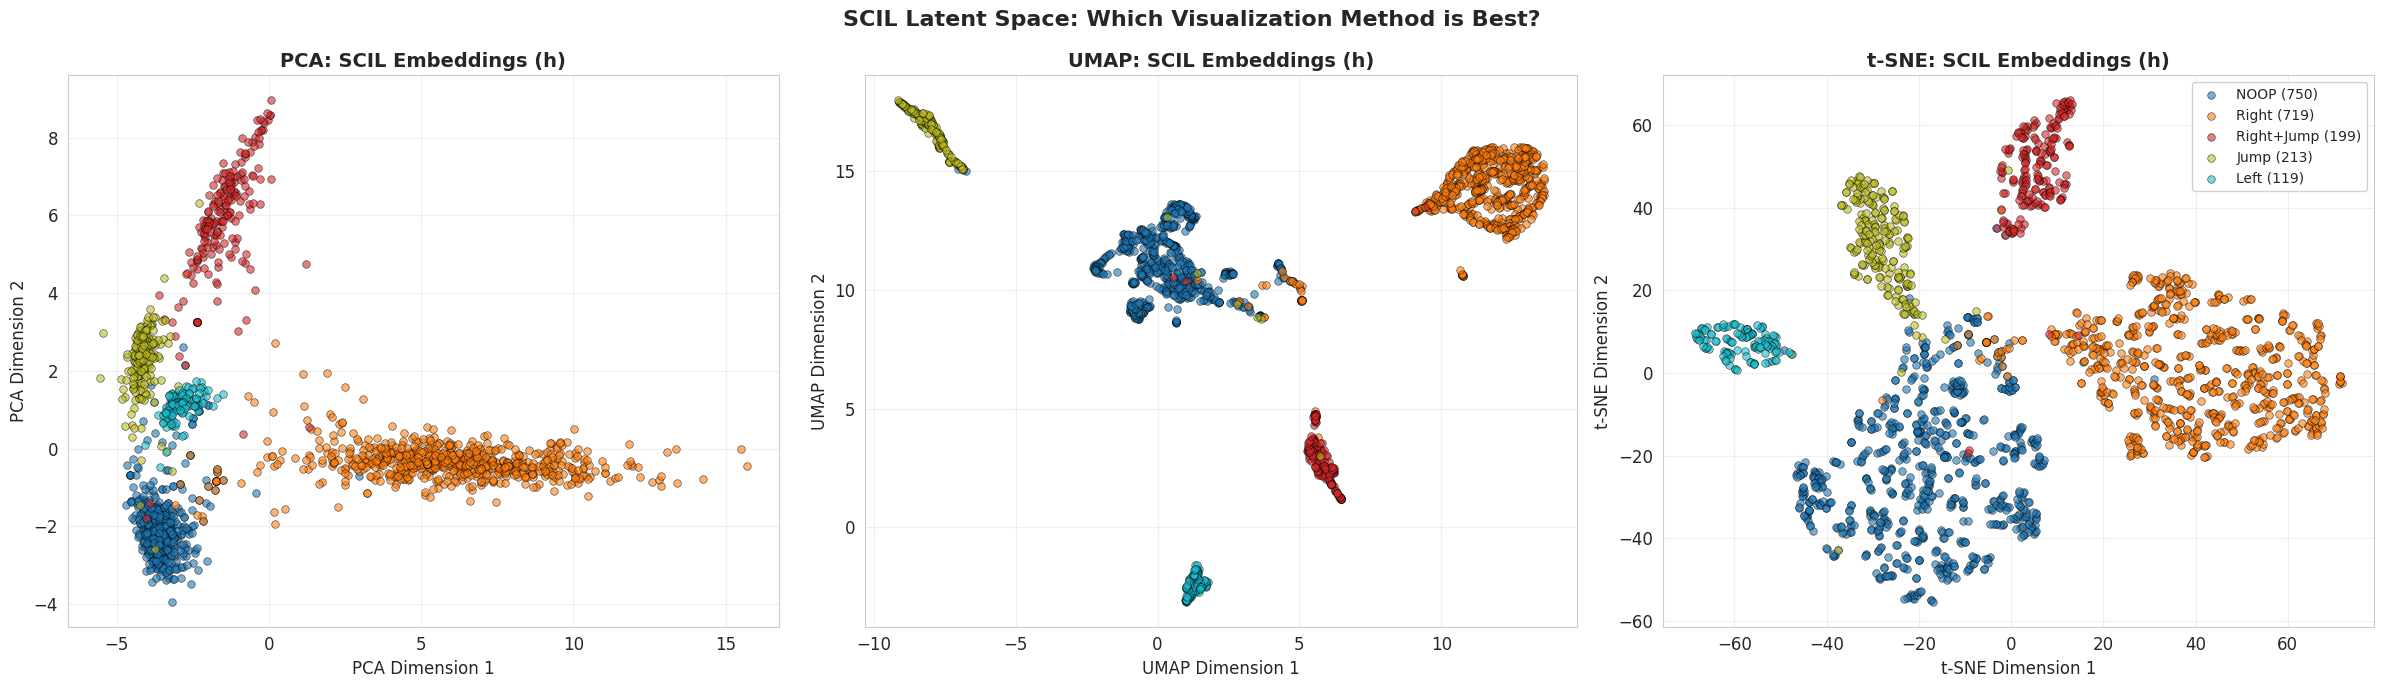


💡 Which method shows the clearest action clustering?
   - PCA: Shows linear global structure (clusters might overlap)
   - UMAP: Best balance of local+global (recommended for modern papers)
   - t-SNE: Emphasizes local structure (most common in older papers)

   Well-separated clusters = SupCon is working!


In [7]:
# COMPARISON PLOT: All three methods side-by-side
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Action names for Mario
action_names = [
    "NOOP",
    "Right", 
    "Right+Jump",
    "Right+Run",
    "Right+Run+Jump",
    "Jump",
    "Left"
]

colors = plt.cm.tab10(np.linspace(0, 1, 7))

methods = [
    ('PCA', embeddings_h_pca),
    ('UMAP', embeddings_h_umap),
    ('t-SNE', embeddings_h_tsne)
]

for idx, (method_name, embeddings_2d) in enumerate(methods):
    for action_id in range(7):
        mask = actions == action_id
        if mask.sum() == 0:
            continue
        axes[idx].scatter(
            embeddings_2d[mask, 0], 
            embeddings_2d[mask, 1],
            c=[colors[action_id]], 
            label=f'{action_names[action_id]} ({mask.sum()})' if idx == 2 else None,
            alpha=0.6, 
            s=30,
            edgecolors='black',
            linewidths=0.5
        )
    
    axes[idx].set_title(f"{method_name}: SCIL Embeddings (h)", fontsize=14, fontweight='bold')
    axes[idx].set_xlabel(f"{method_name} Dimension 1")
    axes[idx].set_ylabel(f"{method_name} Dimension 2")
    axes[idx].grid(True, alpha=0.3)

# Only show legend on rightmost plot
axes[2].legend(loc='best', framealpha=0.9, fontsize=10)

plt.suptitle("SCIL Latent Space: Which Visualization Method is Best?", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('latent_space_all_methods.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Which method shows the clearest action clustering?")
print("   - PCA: Shows linear global structure (clusters might overlap)")
print("   - UMAP: Best balance of local+global (recommended for modern papers)")
print("   - t-SNE: Emphasizes local structure (most common in older papers)")
print("\n   Well-separated clusters = SupCon is working!")

## 3. Dimensionality Reduction Comparison: t-SNE vs UMAP vs PCA

**Note:** The SCIL paper doesn't specify which method they used! Let's try all three:
- **t-SNE**: Preserves local structure, most common in ML papers
- **UMAP**: Preserves both local AND global structure, faster than t-SNE
- **PCA**: Linear projection, shows global structure only

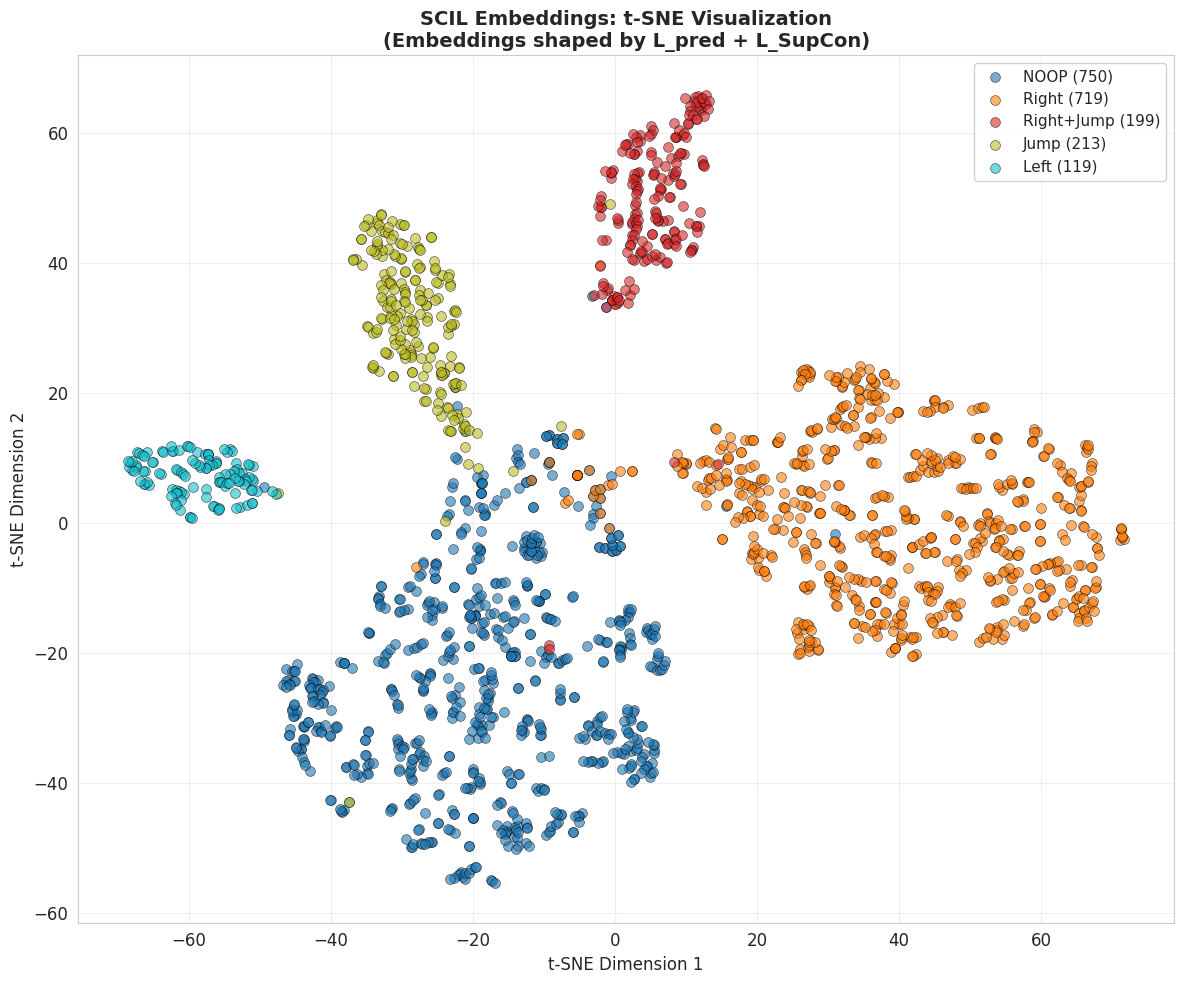


💡 What to look for:
   ✅ Distinct, well-separated clusters = SupCon is working well
   ✅ Tight clusters = similar actions grouped together
   ⚠️  Overlapping clusters = might need higher LAMBDA_SUPCON or more training


In [8]:
# Single large t-SNE visualization (most common in papers)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Action names for Mario
action_names = [
    "NOOP",
    "Right", 
    "Right+Jump",
    "Right+Run",
    "Right+Run+Jump",
    "Jump",
    "Left"
]

colors = plt.cm.tab10(np.linspace(0, 1, 7))

# Plot SCIL embeddings with t-SNE
for action_id in range(7):
    mask = actions == action_id
    if mask.sum() == 0:
        continue
    ax.scatter(
        embeddings_h_tsne[mask, 0], 
        embeddings_h_tsne[mask, 1],
        c=[colors[action_id]], 
        label=f'{action_names[action_id]} ({mask.sum()})',
        alpha=0.6, 
        s=50,
        edgecolors='black',
        linewidths=0.5
    )

ax.set_title("SCIL Embeddings: t-SNE Visualization\n(Embeddings shaped by L_pred + L_SupCon)", 
             fontsize=14, fontweight='bold')
ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
ax.legend(loc='best', framealpha=0.9, fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('latent_space_scil.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 What to look for:")
print("   ✅ Distinct, well-separated clusters = SupCon is working well")
print("   ✅ Tight clusters = similar actions grouped together")
print("   ⚠️  Overlapping clusters = might need higher LAMBDA_SUPCON or more training")

## 4. Per-Action Cluster Analysis

In [9]:
# Analyze variance within each action cluster
print("="*60)
print("PER-ACTION CLUSTER ANALYSIS")
print("="*60)

for action_id in range(7):
    mask = actions == action_id
    if mask.sum() < 2:
        continue
    
    action_emb_h = embeddings_h[mask]
    
    # Compute cluster tightness (std of distances to centroid)
    centroid_h = action_emb_h.mean(axis=0)
    distances_h = np.linalg.norm(action_emb_h - centroid_h, axis=1)
    
    print(f"\nAction {action_id} ({action_names[action_id]}): {mask.sum()} samples")
    print(f"  Cluster spread (std): {distances_h.std():.4f}")
    print(f"  Avg distance to centroid: {distances_h.mean():.4f}")
    
    if distances_h.std() < 10.0:  # Threshold for "tight" cluster
        print(f"  → ✅ Tight cluster!")
    else:
        print(f"  → ⚠️  Loose cluster - actions not well-grouped")

print("\n💡 Lower spread = tighter clusters = better action grouping by SupCon")

PER-ACTION CLUSTER ANALYSIS

Action 0 (NOOP): 750 samples
  Cluster spread (std): 0.7566
  Avg distance to centroid: 2.2662
  → ✅ Tight cluster!

Action 1 (Right): 719 samples
  Cluster spread (std): 1.5591
  Avg distance to centroid: 4.1460
  → ✅ Tight cluster!

Action 2 (Right+Jump): 199 samples
  Cluster spread (std): 1.2250
  Avg distance to centroid: 2.6207
  → ✅ Tight cluster!

Action 5 (Jump): 213 samples
  Cluster spread (std): 1.1761
  Avg distance to centroid: 2.2385
  → ✅ Tight cluster!

Action 6 (Left): 119 samples
  Cluster spread (std): 0.7743
  Avg distance to centroid: 1.9990
  → ✅ Tight cluster!

💡 Lower spread = tighter clusters = better action grouping by SupCon


## 5. Confusion Matrix of Nearest Neighbors

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Use k-NN to evaluate how well actions can be separated in embedding space
print("="*60)
print("k-NN CLASSIFICATION TEST")
print("(Tests how separable actions are in embedding space)")
print("="*60)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_h, actions, test_size=0.3, random_state=42, stratify=actions
)

# Train k-NN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict
y_pred = knn.predict(X_test)
accuracy = (y_pred == y_test).mean()

print(f"\nSCIL Embeddings (h):")
print(f"  k-NN Accuracy: {accuracy*100:.2f}%")

if accuracy > 0.9:
    print("  → ✅ EXCELLENT separability!")
elif accuracy > 0.8:
    print("  → ✅ GOOD separability")
elif accuracy > 0.7:
    print("  → ⚠️  MODERATE separability")
else:
    print("  → ❌ POOR separability")

print("\n💡 High k-NN accuracy = actions are well-separated in embedding space")
print("   This means SupCon + L_pred created good action-based structure!")

k-NN CLASSIFICATION TEST
(Tests how separable actions are in embedding space)

SCIL Embeddings (h):
  k-NN Accuracy: 98.00%
  → ✅ EXCELLENT separability!

💡 High k-NN accuracy = actions are well-separated in embedding space
   This means SupCon + L_pred created good action-based structure!


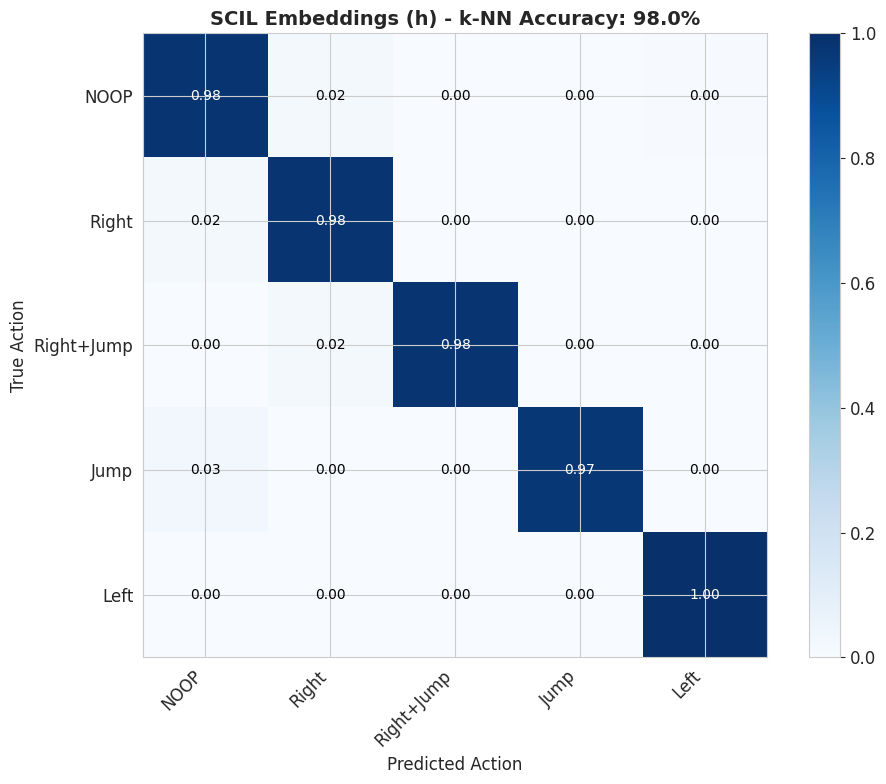


💡 How to read this matrix:
   - Darker diagonal = better action separability
   - Off-diagonal elements = confusion between actions
   - Ideally: dark diagonal, light off-diagonal

Note: Showing 5 actions present in test set (out of 7 total)


In [11]:
# Plot confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cm = confusion_matrix(y_test, y_pred)

# Get the actual labels present in the test set
unique_labels = np.unique(np.concatenate([y_test, y_pred]))
n_labels = len(unique_labels)

# Normalize
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
im = ax.imshow(cm_norm, interpolation='nearest', cmap='Blues')
ax.set_title(f'SCIL Embeddings (h) - k-NN Accuracy: {accuracy*100:.1f}%', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted Action', fontsize=12)
ax.set_ylabel('True Action', fontsize=12)
ax.set_xticks(range(n_labels))
ax.set_yticks(range(n_labels))
ax.set_xticklabels([action_names[i] for i in unique_labels], rotation=45, ha='right')
ax.set_yticklabels([action_names[i] for i in unique_labels])

# Add text annotations (only for labels that exist)
for i in range(n_labels):
    for j in range(n_labels):
        text = ax.text(j, i, f'{cm_norm[i, j]:.2f}',
                      ha="center", va="center", color="white" if cm_norm[i, j] > 0.5 else "black",
                      fontsize=10)

plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig('confusion_matrix_scil.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 How to read this matrix:")
print("   - Darker diagonal = better action separability")
print("   - Off-diagonal elements = confusion between actions")
print("   - Ideally: dark diagonal, light off-diagonal")
print(f"\nNote: Showing {n_labels} actions present in test set (out of 7 total)")

## 6. Summary Report

In [12]:
print("\n" + "="*60)
print("FINAL SUMMARY: IS SCIL WORKING WELL?")
print("="*60)

print(f"\n📊 Quantitative Metrics:")
print(f"   Silhouette Score:   {metrics_h['silhouette']:.4f}")
print(f"   Separation Ratio:   {metrics_h['separation_ratio']:.4f}")
print(f"   k-NN Accuracy:      {accuracy*100:.2f}%")

print(f"\n🎯 Conclusion:")

# Check if SCIL is working well
scil_working = (
    metrics_h['silhouette'] > 0.4 and
    metrics_h['separation_ratio'] > 2.0 and
    accuracy > 0.8
)

if scil_working:
    print("   ✅ SCIL IS WORKING WELL!")
    print("   → Embeddings show good action-based clustering")
    print("   → SupCon loss is creating meaningful structure")
    print("   → These embeddings should transfer well to downstream RL tasks")
    
    if metrics_h['silhouette'] > 0.7 and metrics_h['separation_ratio'] > 3.0 and accuracy > 0.9:
        print("\n   🌟 EXCELLENT quality! No need to tune further.")
    else:
        print("\n   💡 Good quality. Could potentially improve with:")
        print("      - Higher LAMBDA_SUPCON (try 3.0 or 4.0)")
        print("      - Lower TEMPERATURE (try 0.03)")
        print("      - More training epochs")
        print("      - Larger batch size")
else:
    print("   ⚠️ SCIL might not be working optimally")
    print("   → Embeddings don't show strong action-based clustering")
    print("   → Consider:")
    print("      - Increasing LAMBDA_SUPCON significantly (try 5.0)")
    print("      - Checking if prediction loss is too dominant")
    print("      - Training longer")
    print("      - Verifying SupCon loss implementation")

print("\n" + "="*60)
print("💡 Remember: After our fix, embeddings h are shaped by BOTH:")
print("   1. L_pred (action prediction loss)")
print("   2. L_SupCon (supervised contrastive loss on h)")
print("   Good metrics = both losses are working together harmoniously!")
print("="*60)


FINAL SUMMARY: IS SCIL WORKING WELL?

📊 Quantitative Metrics:
   Silhouette Score:   0.5133
   Separation Ratio:   2.6939
   k-NN Accuracy:      98.00%

🎯 Conclusion:
   ✅ SCIL IS WORKING WELL!
   → Embeddings show good action-based clustering
   → SupCon loss is creating meaningful structure
   → These embeddings should transfer well to downstream RL tasks

   💡 Good quality. Could potentially improve with:
      - Higher LAMBDA_SUPCON (try 3.0 or 4.0)
      - Lower TEMPERATURE (try 0.03)
      - More training epochs
      - Larger batch size

💡 Remember: After our fix, embeddings h are shaped by BOTH:
   1. L_pred (action prediction loss)
   2. L_SupCon (supervised contrastive loss on h)
   Good metrics = both losses are working together harmoniously!
